In [1]:
import pandas as pd
import numpy as np

In [2]:
# Preprocess the data
prev_file_path = "Newsbooks_Intermediary_Data/res.csv"
prev_res = pd.read_csv(prev_file_path)
file_path = "CLUSTER_newsbooks_normalized_and_cleaned.csv"
res = pd.read_csv(file_path)

print("Columns that exist in old csv but not in new one", list(set(prev_res.columns) - set(res.columns)))
add_cols = [
    'text_name',
    'Textfile', 'Newsbooks Issue', 'Newsbooks Link', 'VID',
    'EEBO Link', 'Newsbooks Title', 'Newsbooks Date', 
    'Newsbooks Shelfmark', 'Notes', 'Ideology', 'Major/Minor'
]
prev_res['text_name'] = prev_res['text_name'].apply(lambda s: s[:4] + s[-4:])

# Merge the previous datasets' column into the new dataset
res = res.merge(prev_res[add_cols], left_on='text_name', right_on='text_name')

Columns that exist in old csv but not in new one ['Notes', 'Newsbooks Issue', 'text_key_x', 'text_key_y', 'Ideology', 'VID', 'Newsbooks Title', 'Newsbooks Link', 'Newsbooks Shelfmark', 'Major/Minor', 'EEBO Link', 'TSNE_x', 'PCA_x', 'TSNE_y', 'PCA_y', 'Newsbooks Date', 'Textfile']


In [3]:
def eda_fn(x):
    uniq_lst = pd.unique(x).tolist()
    n = len(uniq_lst)
    return n, uniq_lst

pd.set_option('display.max_rows', 100)
res_info = res.apply(lambda x: eda_fn(x)).transpose()
res_info['dtype'] = res.dtypes
res_info.reset_index(inplace=True)
res_info.columns = ['feature', 'nunique', 'unique values', 'dtype']

numerical_var_lst = res_info[
                               (res_info['feature'] != 'Ideology')
                               & (res_info['dtype'] != "object") 
                               & (res_info['nunique'] > 1)
                              ]['feature'].tolist()
print("Number of Numerical Columns are", len(numerical_var_lst))

Number of Numerical Columns are 68


In [4]:
# Scale the numerical data
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(res[numerical_var_lst])

scaled_data = scaler.transform(res[numerical_var_lst])
df_scaled = pd.DataFrame(scaled_data, columns=numerical_var_lst)

# Label Encode the target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_target = res['Ideology'].to_frame().apply(le.fit_transform)
res['Encoded_Ideology'] = encoded_target
target_classes = np.append(le.classes_[:-1], "NAN")

print(le.classes_)

# Fill in the NA values
df_scaled[df_scaled.isna().any(axis=1)] # there is only two rows with nan values
df_scaled = df_scaled.fillna(0)

['Army' 'Leveler' 'Parliamentarian' 'Royalist' nan]


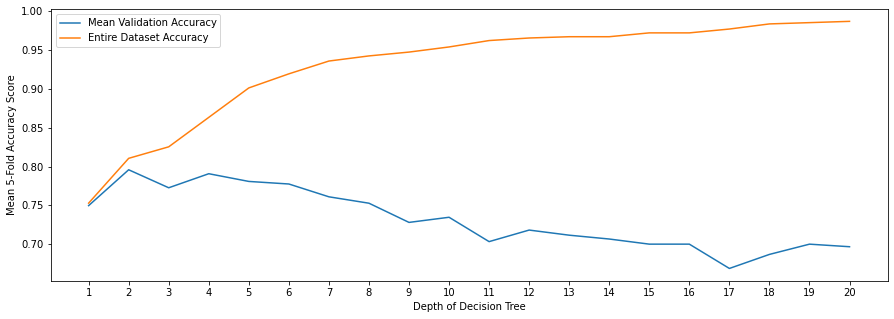

In [5]:
# Decision Tree Classifer
np.random.seed(36490) 

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz 
from graphviz import Source


cv = 5
d_lst = np.arange(1, 21)
mean_acc_score = []
total_acc_score_lst = []
for d in d_lst:
    clf = DecisionTreeClassifier(max_depth=d)
    clf_score = cross_val_score(clf, df_scaled, encoded_target, cv=cv, scoring="accuracy")
    clf.fit(df_scaled, encoded_target)
    total_acc = clf.score(df_scaled, encoded_target)
    mean_clf_score = np.mean(clf_score)
    mean_acc_score.append(mean_clf_score)
    total_acc_score_lst.append(total_acc)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(d_lst, mean_acc_score, label = "Mean Validation Accuracy")
ax.plot(d_lst, total_acc_score_lst, label = "Entire Dataset Accuracy")

ax.set_xlabel('Depth of Decision Tree')
ax.set_ylabel('Mean %d-Fold Accuracy Score' % cv)
ax.set_xticks(d_lst)
ax.set_ylim(plt.ylim())
ax.legend()

'tree.dot.pdf'

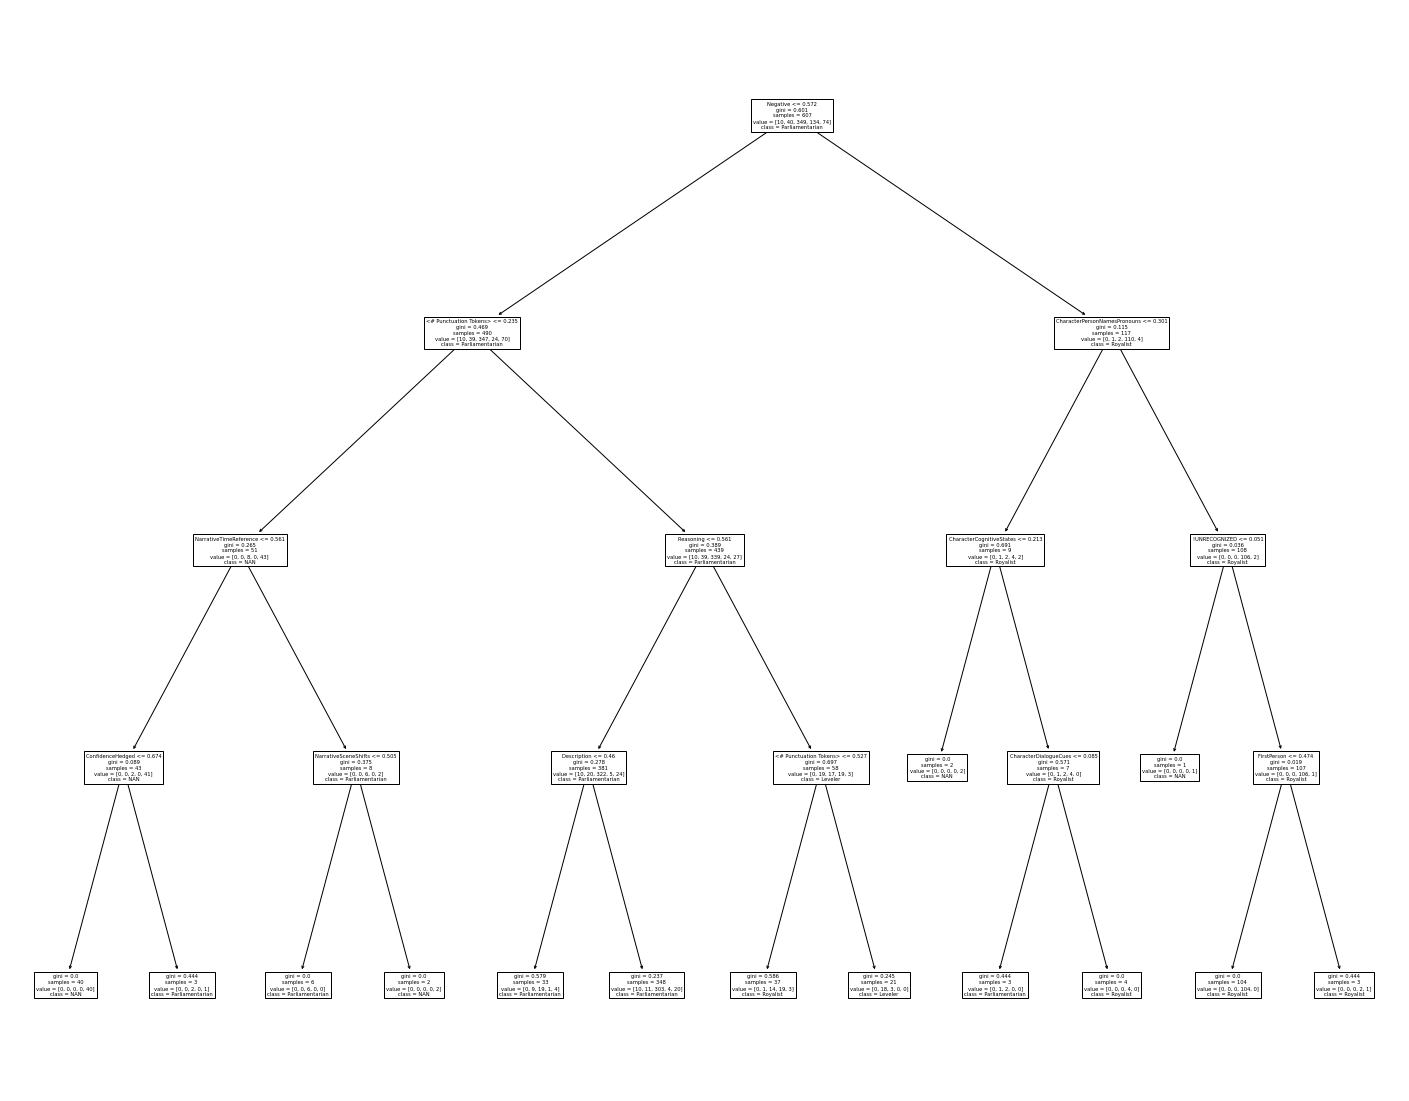

In [6]:
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(df_scaled, encoded_target)

ig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,feature_names=df_scaled.columns,class_names=target_classes)
plt.savefig('Decision_Tree_Depth_4.png')
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df_scaled.columns,
                                class_names=target_classes)
graph = graphviz.Source(dot_data)
graph.render("tree.dot",view = True)

In [7]:
len(clf.feature_importances_), clf.feature_importances_
import_lst = clf.feature_importances_.nonzero()[0]
import_cols = df_scaled.columns[import_lst].tolist()
print("There are %d important features:" % len(import_cols), import_cols)
df_scaled.loc[:,import_cols]

There are 12 important features: ['!UNRECOGNIZED', 'CharacterCognitiveStates', 'CharacterDialogueCues', 'CharacterPersonNamesPronouns', 'ConfidenceHedged', 'Description', 'FirstPerson', 'NarrativeSceneShifts', 'NarrativeTimeReference', 'Negative', 'Reasoning', '<# Punctuation Tokens>']


,!UNRECOGNIZED,CharacterCognitiveStates,CharacterDialogueCues,CharacterPersonNamesPronouns,ConfidenceHedged,Description,FirstPerson,NarrativeSceneShifts,NarrativeTimeReference,Negative,Reasoning,<# Punctuation Tokens>
0,0.075655,0.312740,0.054683,0.335005,0.864628,0.571705,0.307431,0.454804,0.189796,0.387956,0.472717,0.328844
1,0.070936,0.172092,0.000000,0.439933,0.676002,0.527245,0.258454,0.439702,0.162014,0.475248,0.399973,0.342312
2,0.044650,0.217037,0.000000,0.305498,0.848625,0.599388,0.055878,0.557983,0.270668,0.353577,0.357538,0.284512
3,0.066535,0.195750,0.026893,0.323825,0.637827,0.475439,0.010079,0.279587,0.186681,0.460631,0.457459,0.384961
4,0.060338,0.358575,0.086209,0.519034,0.306697,0.638261,0.000000,0.448129,0.437316,0.428133,0.324543,0.244669
...,...,...,...,...,...,...,...,...,...,...,...,...
602,0.097123,0.344707,0.232050,0.322136,0.655191,0.657456,0.323041,0.321662,0.354023,0.584604,0.545407,0.281706
603,0.177134,0.427029,0.342224,0.242188,0.432886,0.611158,0.256532,0.023719,0.201012,0.790813,0.534420,0.262065
604,0.115743,0.416577,0.350540,0.428442,0.593847,0.494337,0.412917,0.347079,0.187179,0.761307,0.670294,0.210438
605,0.090559,0.378804,0.033117,0.437253,0.602181,0.493349,0.198599,0.275439,0.106102,0.513542,0.443283,0.301347


In [9]:
df_scaled_all = df_scaled
info_cols = [
    'Ideology', 'text_name', 'Encoded_Ideology',
    'Newsbooks Title', 'Newsbooks Date', 'Notes']
for col in info_cols:
    df_scaled_all[col] = res[col]

In [10]:
df_scaled_all.to_csv("new_df_scaled_all.csv")